In [9]:
import pandas as pd
import numpy as np
import collections


import datasets
from datasets import Dataset, Value, ClassLabel, Features
from datasets import load_metric

import torch
from torch import nn

import transformers
from transformers import RobertaTokenizerFast
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from transformers import Trainer

import os
import shutil

import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt 

### Final preprocessing of benchmark data

In [19]:
def normalize_tokens(row):
    tmp_tok = row['tok'].lower()
    tmp_tok = tmp_tok.replace("'",'').replace('=','').replace('_','').replace('-','').replace('@@','*').replace('@','*').replace('#',",").replace('dummy',",")
    return tmp_tok

In [28]:
BENCHMARK_REDUC_FR = 'data/benchmark_reduc_fr.csv'
BENCHMARK_BC_FR = 'data/benchmark_bc_fr.csv'
BENCHMARK_PROM_FR = 'data/benchmark_prom_fr.csv'

RESULT_FOLDER ="results/"
FIGS_FOLDER ="figs/"
MODELS_FOLDER ="models/"

PRETRAINED_MODELS_FOLDER ="../toy_llm/models/"


df_red = pd.read_csv(BENCHMARK_REDUC_FR)
df_bc = pd.read_csv(BENCHMARK_BC_FR)
df_prom = pd.read_csv(BENCHMARK_PROM_FR)

df_red['tok'] = df_red['tok'].fillna(',') 
df_bc['tok'] = df_bc['tok'].fillna(',')
df_prom['tok'] = df_prom['tok'].fillna(',')

df_red['tok'] = df_red.apply(normalize_tokens,axis=1)
df_bc['tok'] = df_bc.apply(normalize_tokens,axis=1)
df_prom['tok'] = df_prom.apply(normalize_tokens,axis=1)


df_bc['dur'] = df_bc['end']-df_bc['start']
df_prom['dur'] = df_prom['end']-df_prom['start']

df_red['label'] = df_red['reduc_ratio']<0.7
df_bc['label'] = df_bc['backchanneled']
df_prom['label'] = df_prom['prom']>1.25


In [30]:
#Unused (did not bring anything)

#df_red['prev_red'] = df_red['label_reduc'].shift(1)
#df_red['next_red'] = df_red['label_reduc'].shift(-1)

#def smooth_reduc(row):
#    if not row['label_reduc'] and row['prev_red'] and row['next_red'] and row['tok'] != '#':
#        return True
#    else:
#        return row['label_reduc']
        
#df_red['label_smooth_reduc'] = df_red.apply(smooth_reduc,axis=1)


### Checking Label Distributions

In [ ]:
df_red['reduc_ratio'].plot()

In [4]:
pd.Series(collections.Counter(df_red['label']))

False    49218
True     24108
dtype: int64

In [5]:
24108/(49218+24108)

0.3287783323786924

In [13]:

import matplotlib.pyplot as plt 

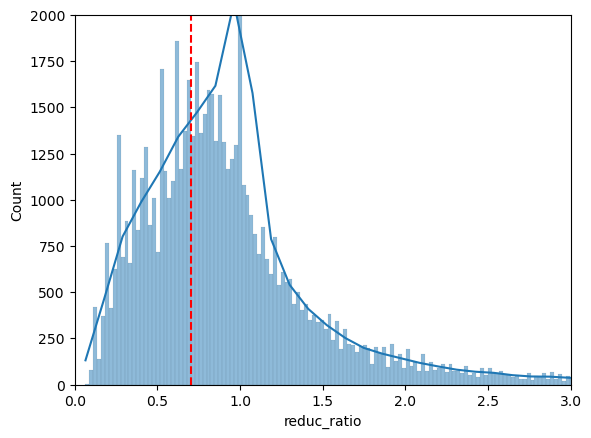

In [26]:
#sns.histplot(data=df_red, x="reduc_ratio",ylim(0,2500),xlim=(0,5), kde=True)

plt.clf()
sns.histplot(df_red["reduc_ratio"],kde=True)
plt.xlim(0, 3)
plt.ylim(0, 2000)
plt.axvline(0.7,color='red',linestyle='--')
plt.savefig('df_reduc_ratio.png')

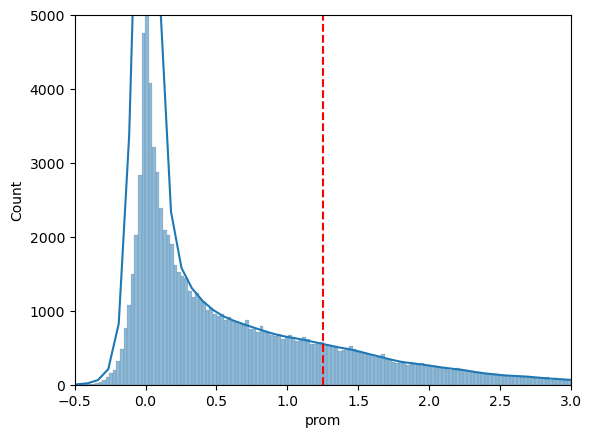

In [32]:
#sns.histplot(data=df_red, x="reduc_ratio",ylim(0,2500),xlim=(0,5), kde=True)

plt.clf()
sns.histplot(df_prom["prom"],kde=True)
plt.xlim(-0.5, 3)
plt.ylim(0, 5000)
plt.axvline(1.25,color='red',linestyle='--')
plt.savefig('df_prom_ratio.png')

In [6]:
pd.Series(collections.Counter(df_bc['label']))

False    67659
True      5667
dtype: int64

In [30]:
pd.Series(collections.Counter(df_prom['label']))

False    122276
True      19566
dtype: int64

In [31]:
19566/(122276+19566)

0.1379422173968218

### Add folds

In [29]:
FOLDS = {1:['AB','CM'],2:['AC','MB'],3:['AG','YM'],4:['AP','LJ'],5:['BX','MG'],6:['EB','SR'],7:['IM','ML'],8:['NH','LL']}

def addfold(row):
    for fold in FOLDS.keys():
        if row['spk'] in FOLDS[fold]:
            return fold

df_bc['fold'] = df_bc.apply(addfold,axis=1)
df_red['fold'] = df_red.apply(addfold,axis=1)
df_prom['fold'] = df_prom.apply(addfold,axis=1)

### Changing structure of data set
#### From 1 line = 1 token to 1 line = 1 "sentence" (actually Inter-Pausal Unit)

In [30]:
def token2sent(df,threshold=0.5):
    res = []
    
    tmp_toks = []
    tmp_labels = []

    for index,row in df.iterrows():
        if (row['tok'] in ['#','dummy',',']) and row['dur'] > threshold:
            if tmp_toks != []:
                res.append([tmp_toks,tmp_labels,row['fold']])#
                tmp_toks = []
                tmp_labels = []
        else:
            tmp_toks.append(row['tok'])
            tmp_labels.append(int(row['label']))
    return pd.DataFrame(res,columns=['tok','label','fold']) 

df_red_ready = token2sent(df_red)
df_bc_ready = token2sent(df_bc)
df_prom_ready = token2sent(df_prom)


In [10]:
df_prom_ready.iloc[10:20]

,tok,label,fold
10,"[moi, je, peux, prendre, ça, comme, quelque, c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1
11,"[particulier, ,, aussi, ,, particulier]","[1, 0, 0, 0, 1]",1
12,"[qui, ne, coule, pas, de, source, ,, qui]","[0, 0, 0, 0, 0, 1, 0, 1]",1
13,"[qui, peuvent, être, extraordinaires]","[0, 0, 0, 1]",1
14,[mh],[0],1
15,"[tout, t, était, normal, logique]","[0, 0, 0, 0, 1]",1
16,"[bon, je, vois, que, tu, es, tellement, à, cou...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
17,[oui],[1],1
18,"[c, est, une, région, perdue, du, canada, oui,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
19,[mh],[1],1


### Create BIO Labels from binary
##### There is an option to keep the labels binary (all '1' become 'B-XXX')

In [51]:
def bin2bio(row,label_str,pure_binary=False):
    binlist = row['label']
    res = []
    prev = 0
    for item in binlist:
        if item == 1 :
            if prev != 1:
                res.append('B-'+label_str) 
            else:
                if not pure_binary:
                    res.append('I-'+label_str)
                else:
                    res.append('B-'+label_str)
            prev = 1
        else:
            res.append('O')
            prev = 0
    return res

df_red_ready ['label_bio'] = df_red_ready.apply(bin2bio,args=('RED',False),axis=1)
df_bc_ready ['label_bio'] = df_bc_ready.apply(bin2bio,args=('BC',False),axis=1)
df_prom_ready ['label_bio'] = df_prom_ready.apply(bin2bio,args=('PROM',False),axis=1)


### Create HF datasets from the dataframes

In [35]:
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

In [37]:
dataset_prom = Dataset.from_pandas(df_prom_ready)
dataset_prom = dataset_prom.map(lambda ex: {"tags": ex["label_bio"]}) #red_bio
all_labels_prom = get_label_list(dataset_prom["tags"])
dataset_prom = dataset_prom.cast_column("tags", datasets.Sequence(datasets.ClassLabel(names=all_labels_prom)))
label_list_prom = dataset_prom.features["tags"].feature.names
# unused now
#label_all_tokens = True # change this flag to label only first subtoken of a token

Map:   0%|          | 0/9369 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9369 [00:00<?, ? examples/s]

In [63]:
dataset_bc = Dataset.from_pandas(df_bc_ready)
dataset_bc = dataset_bc.map(lambda ex: {"tags": ex["label_bio"]}) #red_bio
all_labels_bc = get_label_list(dataset_bc["tags"])
dataset_bc = dataset_bc.cast_column("tags", datasets.Sequence(datasets.ClassLabel(names=all_labels_bc)))
label_list_bc = dataset_bc.features["tags"].feature.names
# unused now
#label_all_tokens = True # change this flag to label only first subtoken of a token


Map:   0%|          | 0/4854 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4854 [00:00<?, ? examples/s]

In [38]:
dataset_red = Dataset.from_pandas(df_red_ready)
dataset_red = dataset_red.map(lambda ex: {'tags': ex["label_bio"]}) #red_bio
all_labels_red = get_label_list(dataset_red['tags'])
dataset_red = dataset_red.cast_column('tags', datasets.Sequence(datasets.ClassLabel(names=all_labels_red)))
label_list_red = dataset_red.features['tags'].feature.names
# unused now
#label_all_tokens = True # change this flag to label only first subtoken of a token


Map:   0%|          | 0/4849 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4849 [00:00<?, ? examples/s]

# More tools for running the experiments

### Function to handle labels and subwords

In [39]:
# adapted from HF examples
def tokenize_and_align_labels(examples,tokenizer):
    
    tokenized_inputs = tokenizer(examples["tok"], padding='max_length', truncation=True, is_split_into_words=True)
    
    labels = []
    
    for i, label in enumerate(examples["tags"]):
        
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                # Modified to make sure it follows the BIO scheme
                if label[word_idx]==0:
                    good_label = 1
                else:
                    good_label = label[word_idx]
                label_ids.append(good_label)
            previous_word_idx = word_idx

        labels.append(label_ids)
 
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


### Custom Trainer when we want weights for evaluating the labels


In [62]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 0.2]).to('cuda'))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Compute metrics

In [40]:
metric = load_metric("seqeval")

def prepare_compute_metric_with_labellist(label_list):
    def compute_metric(p):
        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (special tokens)
        true_predictions = [
            [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
            ]
    
        true_labels = [
            [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
            ]

        results = metric.compute(predictions=true_predictions, references=true_labels)
        return {
            "f1": results["overall_f1"],
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "accuracy": results["overall_accuracy"],
        }
    return compute_metric



/tmp/ipykernel_6915/1639155487.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/prevot/anaconda3/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [67]:
def run_one_fold(task,fold,split_dataset,checkpoint,tokenizer,label_list,weighted=False,verbose=False,error_analysis=False,keep_models=False):
    
    print(fold)
 
    tokenized_split_dataset = split_dataset.map(lambda d : tokenize_and_align_labels(d,tokenizer), batched=True)
 
    model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=len(label_list))
    
    if verbose:
        print(model)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device in use:",device)
    
    #model.to('cuda')                                      #####
    
    if len(checkpoint.split("/"))>1:
        model_name = str(fold)+'-'+checkpoint.split("/")[-2]
    else:
        model_name = str(fold)+'-'+checkpoint
        
    print(model_name)
   
    args = TrainingArguments(
        MODELS_FOLDER+model_name+"-finetuned-"+task,
        evaluation_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        )

    
    data_collator = DataCollatorForTokenClassification(tokenizer)

    compute_metric = prepare_compute_metric_with_labellist(label_list)
    
    if weighted:
        trainer = CustomTrainer(model,args,
                          tokenized_split_dataset["train"],
                          tokenized_split_dataset["valid"],
                          data_collator=data_collator,tokenizer=tokenizer,compute_metrics=compute_metric)
    else:
        trainer = Trainer(model,args,
                          train_dataset=tokenized_split_dataset["train"],
                          eval_dataset=tokenized_split_dataset["valid"],
                          data_collator=data_collator,tokenizer=tokenizer,compute_metrics=compute_metric) 
        

    trainer.train()
    
    predictions, labels, _ = trainer.predict(tokenized_split_dataset["test"])
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
        ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
        ]
    
    if error_analysis:
        EA_df = pd.DataFrame(tokenized_split_dataset["test"])
        EA_df['predict'] = true_predictions
        EA_df['gold'] = true_labels
        EA_df.to_csv(RESULT_FOLDER+"error_analysis_"+task+"_"+str(fold)+'.csv')

    if not keep_models:
        shutil.rmtree(MODELS_FOLDER+model_name+"-finetuned-"+task)
    
    return metric.compute(predictions=true_predictions, references=true_labels)

In [68]:
def run_crossvalid(task,base_dataset,checkpoint,label_list,weighted=False,verbose=False,error_analysis=False,keep_models=False):
    
    tokenizer = RobertaTokenizerFast.from_pretrained(checkpoint, max_len=512,add_prefix_space=True)
    
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

    results = {'fs':[],'prec':[],'rec':[]}
    for i in range(1,9):
        print(i)
        split_ds = datasets.DatasetDict({
            'train': base_dataset.filter(lambda example: example["fold"] not in [i,(i%8+1)]),
            'test': base_dataset.filter(lambda example: example["fold"] == i),
            'valid': base_dataset.filter(lambda example: example["fold"] == i%8+1)
        })
        print(label_list)
        res = run_one_fold(task,i,split_ds,checkpoint,tokenizer,label_list,weighted,verbose,error_analysis,keep_models)
        print(res.keys())
        results['fs'].append(res['overall_f1'])
        results['prec'].append(res['overall_precision'])
        results['rec'].append(res['overall_recall'])
    return results

In [66]:
os.listdir(PRETRAINED_MODELS_FOLDER)

['fr_10M_4K_wiki',
 'fr_10M_52K_conv',
 'fr_10M_4K_conv',
 'fr_10M_52K_wiki',
 'fr_10M_10K_wiki',
 'fr_10M_10K_conv']

# Run experiments

In [69]:
def run_complete_expe_new(expe_name,ds,models_to_test,label_list,weighted=False,verbose=False,error_analysis=True,keep_models=False):
    
    models_to_test = models_to_test

    ds = ds.remove_columns("label")
    print('====')
    print(expe_name)
    print('====')
    
    res_cv = {}
    
    for model in models_to_test:
        print(model)
        res_cv[model] = pd.DataFrame(run_crossvalid(expe_name,ds,PRETRAINED_MODELS_FOLDER+model,label_list,
                                 weighted,verbose,error_analysis,keep_models))
        res_cv[model]['model'] = model.split('_')[-1]
        
    print('running roberta')
    res_cv['roberta'] = pd.DataFrame(run_crossvalid(expe_name,ds,'xlm-roberta-base',label_list,
                                weighted,verbose,error_analysis,keep_models))
    res_cv['roberta']['model'] = 'roberta'

    print(res_cv)
    res_cv_all = pd.concat(res_cv.values())

    res_cv_all.to_csv(RESULT_FOLDER+expe_name+'_'+'_'.join(models_to_test)+'.csv')

    plot = sns.boxplot(data=res_cv_all,x='model',y='fs')
    plot.figure.savefig(FIGS_FOLDER+expe_name+'_'+'_'.join(models_to_test)+'_fscore.png',dpi=300)
    plot.figure.clf() 

    plot = sns.boxplot(data=res_cv_all,x='model',y='prec')
    plot.figure.savefig(FIGS_FOLDER+expe_name+'_'+'_'.join(models_to_test)+'_prec.png',dpi=300)
    plot.figure.clf() 

    plot = sns.boxplot(data=res_cv_all,x='model',y='rec')
    plot.figure.savefig(FIGS_FOLDER+expe_name+'_'+'_'.join(models_to_test)+'_rec.png',dpi=300)
    plot.figure.clf() 
    return 0




In [ ]:
run_complete_expe_new('red',dataset_red, os.listdir(PRETRAINED_MODELS_FOLDER),label_list_red)
run_complete_expe_new('prom',dataset_prom, os.listdir(PRETRAINED_MODELS_FOLDER),label_list_prom)
# Currently broken....
# run_complete_expe_new('bc',dataset_bc, os.listdir(PRETRAINED_MODELS_FOLDER),label_list_bc,weighted=True)


## Plots and Significance

In [76]:
prom_expe_10K_df = pd.read_csv('results/prom_fr_10M_10K_conv_fr_10M_10K_wiki.csv')
red_expe_10K_df = pd.read_csv('results/red_fr_10M_10K_conv_fr_10M_10K_wiki.csv')

#prom_expe_52K_df = pd.read_csv('results/prom_fr_10M_52k.csv')
#red_expe_52K_df = pd.read_csv('results/red_fr_10M_52K_conv_fr_10M_52K_wiki.csv')

#prom_expe_4K_df = pd.read_csv('results/prom_fr_10M_10K_conv_fr_10M_10K_wiki.csv')
#red_expe_4K_df = pd.read_csv('results/red4K_cv.csv')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wiki vs. conv: Mann-Whitney-Wilcoxon test two-sided, P_val:1.088e-03 U_stat=3.000e+00


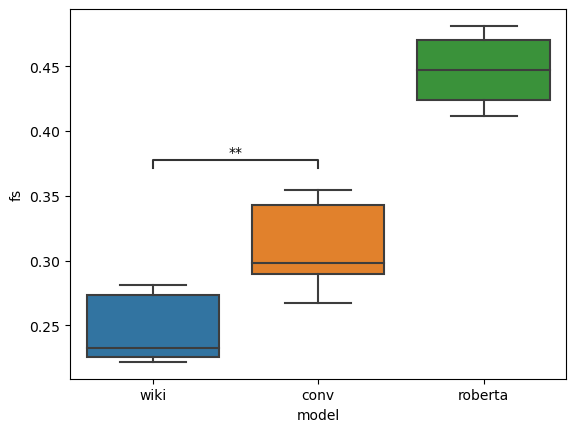

In [77]:
#df['expe'] = df['expe'].replace({'char02':'base','rompc1':'r_1','charpc1':'c_1','romws':'r_ws','charws':'c_ws','rompc10':'r_10','charpc10':'c_10','romgold':'r_100','chargold':'c_100'})
#data_df = data_df.rename(columns={"label": "tok",'filename':'speaker'})
order = ['wiki','conv','roberta']

#my_pal = {'base':'y','r_1':'cyan','c_1':'pink','r_ws':'c','c_ws':'palevioletred','r_10':'cyan','c_10':'pink','r_100':'cyan','c_100':'pink'}

#x = "model"
#y = "fs"

#order = ['rom','rom+pros','char','char+pros']
pairs = [('wiki','conv')]
ax = sns.boxplot(data=prom_expe_10K_df, x="model", y="fs", order=order) #,palette=my_pal
#ax.set(ylim=((0.0,0.6)))
annot = Annotator(ax, pairs, data=prom_expe_10K_df, x="model", y="fs", order=order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#annot.set_pvalues([0.05])
annot.apply_test()
ax, test_results = annot.annotate()
plt.savefig(FIGS_FOLDER+"prom_10K_annotated_fr.png", dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wiki vs. conv: Mann-Whitney-Wilcoxon test two-sided, P_val:3.823e-01 U_stat=2.300e+01


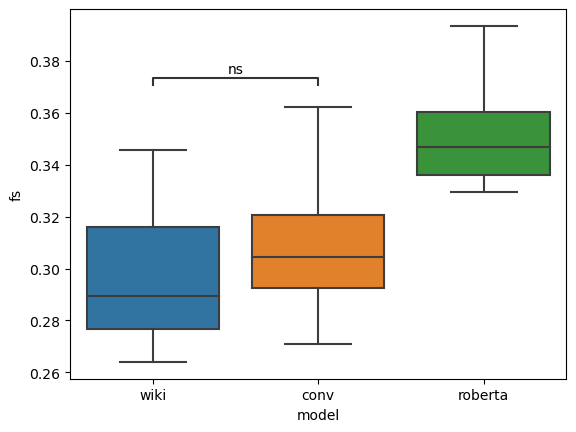

In [78]:
order = ['wiki','conv','roberta']

pairs = [('wiki','conv')]

ax = sns.boxplot(data=red_expe_10K_df, x="model", y="fs", order=order) #,palette=my_pal
#ax.set(ylim=((0.0,0.6)))
annot = Annotator(ax, pairs, data=red_expe_10K_df, x="model", y="fs", order=order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#annot.set_pvalues([0.05])
annot.apply_test()
ax, test_results = annot.annotate()
plt.savefig(FIGS_FOLDER+"red_10K_annotated_fr.png", dpi=300, bbox_inches='tight')